In [104]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,4)
plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["font.size"] = 16

import dask.dataframe as dd
import pandas as pd
import numpy as np
import time

import plotly.io as pio
pio.renderers.default = 'notebook'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from dope.pools.pools import Pool
from dope.backengine.maestro import BackEngineMaestro

In [80]:
maestro = BackEngineMaestro()
pools = [
  Pool(
    chain="Optimism",
    symbol="rETH-ETH",
    protocol="MoonWell",
    ltv=0.83,
    LT=0.83,
    debt_token="ETH",
    debt_token_keyid="ethereum",
    debt_pool_id="f65459ef-ebfa-496d-8f3f-23a328c6e78d",
    deposit_token="rETH",
    deposit_token_keyid="rocket-pool-eth",
    deposit_pool_id="ef5bba25-3891-4215-973c-ad1c647e6152",
  ),
]

In [81]:
# Download data
_ = maestro.load_pools_data(pools)

Optimism:moonwell:ETH f65459ef-ebfa-496d-8f3f-23a328c6e78d 83 83
Optimism:moonwell:RETH ef5bba25-3891-4215-973c-ad1c647e6152 83 83


In [82]:
# The data is downloaded only once
_ = maestro.load_pools_data(pools)

In [83]:
# Download price data
maestro.load_price_data(pools)

Data for rocket-pool-eth with 366 rows
Data for ethereum with 366 rows


In [84]:
# The data is downloaded only once 
maestro.load_price_data(pools)

# Plotting Data

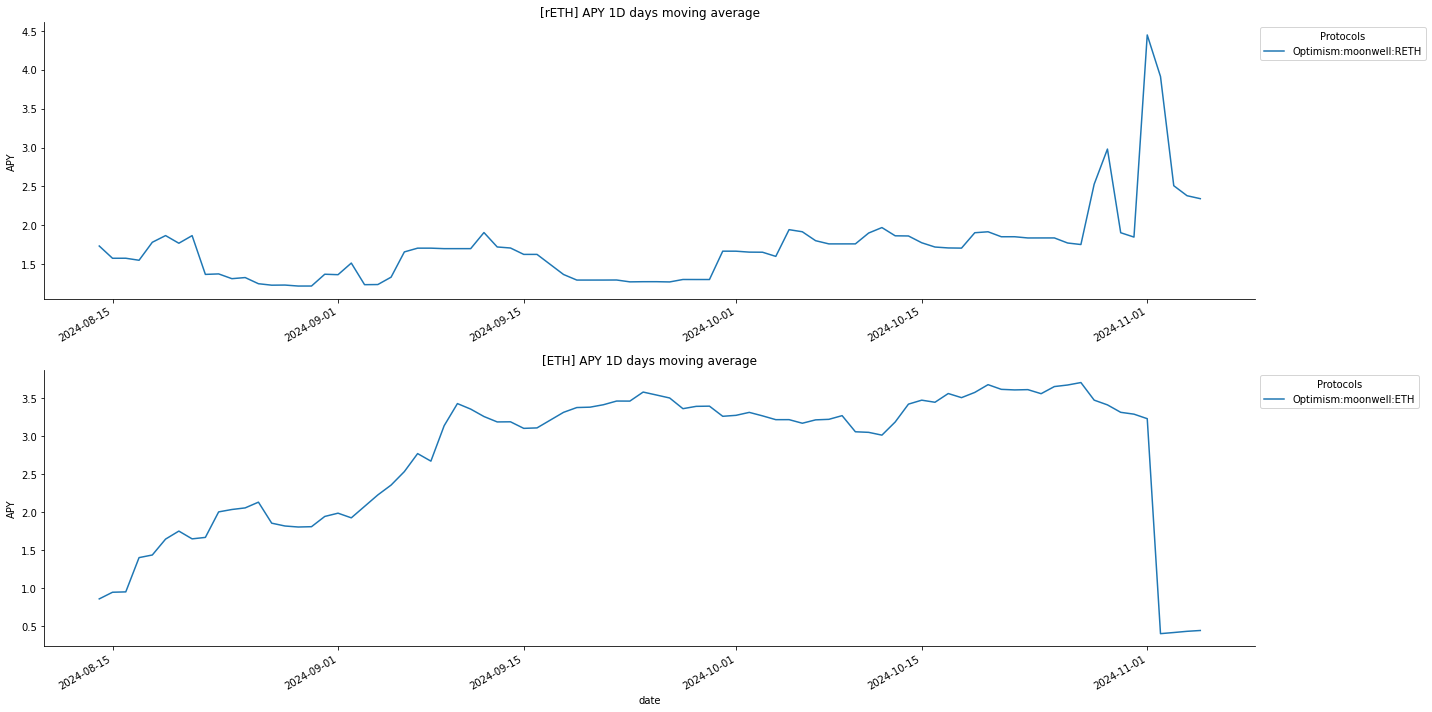

In [85]:
maestro.plot_rates_ts(maestro.rates_data_collection, rate_column='apyBase')

In [86]:
# from dope.backengine.estimators.estimator import Estimator
# from dope.backengine.estimators.clippedestimator import ClippedEstimator
# from dope.backengine.triggers.confidencebandtrigger import ConfidenceBandTrigger

# from dope.backengine.maestro import BackEngineMaestro
# _data = pd.concat(borrow_lend_data['stETH'], names=["datetime"]).unstack(level=0)
# lag = 7 # 1 week window for mu and sigma estimation
# triggerObj = ConfidenceBandTrigger(_data, lag, Estimator(), rt_col='apyBaseBorrow')
# triggers2 = triggerObj.dates()

# BackTester

In [87]:
from dope.backengine.agents.ptlooper import PTLooper
from dope.backengine.agents.onelooper import OnePoolLooper
from dope.backengine.loopengine import LoopBacktester
from dope.token import Token

In [88]:
# run_data = borrow_lend_data.convert_tvl_from_usd(eth)

In [89]:
pair_pool, deposit_pool = pools[-1], pools[-1]
pair_pool, deposit_pool

(Optimism:MoonWell:(debt:ETH(f65459ef-e), deposit:rETH(ef5bba25-3)),
 Optimism:MoonWell:(debt:ETH(f65459ef-e), deposit:rETH(ef5bba25-3)))

In [ ]:
def do_loop(
        self,
        init_capital,
        pair_pool,
        deposit_pool,
        loop_times
    ):
        deposit_pool = self.engine.pools[deposit_pool]
        pair_pool = self.engine.pools[pair_pool]
        
        # initial deposit
        x = init_capital
        if self.verbose:
            print(
                "Loop Algebra Prediction",
                "Deposit:", total_collateral(loop_times, x, pair_pool.ltv-self.buffer), 
                "Debt:", total_borrow(loop_times-1, x, pair_pool.ltv-self.buffer)
            )

        for _ in range(loop_times):
            x = self.engine.swap(
                x.value,
                from_token=deposit_pool.debt_token,
                to_token=pair_pool.deposit_token,
            )
            x = self.engine.add_deposit_token(pair_pool, x)
            x = self.engine.take_debt_token(
                pair_pool,
                Token(
                    x.value * (pair_pool.ltv - self.buffer), 
                    name=pair_pool.debt_token
                ),
            )

        x = self.engine.swap(
                x.value,
                from_token=deposit_pool.debt_token,
                to_token=pair_pool.deposit_token,
            )
        x = self.engine.add_deposit_token(pair_pool, x)

In [142]:
summary = {}

capital = Token(1, "ETH")
loop = 10

for leverage in [1, 2, 3, 4, 5]:
  strategy = OnePoolLooper(
    capital=capital,
    pair_pool=pair_pool,
    deposit_pool=deposit_pool,
    loop_n=OnePoolLooper.loops_from_leverage(leverage, pair_pool, epsilon=0.1),
    buffer=0.01
  )
  strategy.verbose=False

  maestro.convert_data_to_base_token("ETH")

  # uncomment next line to output values in dollar terms
  # maestro.convert_data_to_base_token("dollar")

  bt = LoopBacktester(
    strategy=strategy,
    data=maestro.rates_data_in_base_token,
    price_data=maestro.price_data_collection, 
    pools=maestro.pools,
  )
  #summary[f"loop:{leverage}x"] = bt(start_timestamp="2024-09-22")
  summary[f"loop:{leverage}x"] = bt(start_timestamp="2024-10-01")

Running Backtest for 83
Running Backtest for 83
Running Backtest for 83
Running Backtest for 83
Running Backtest for 83


# Analysis

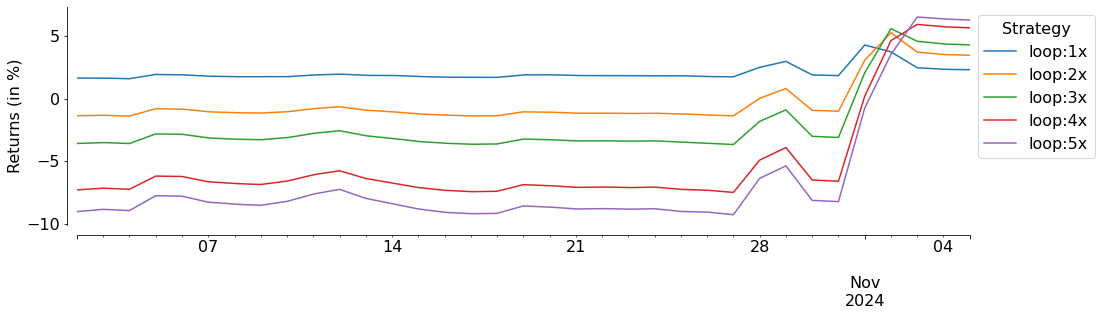

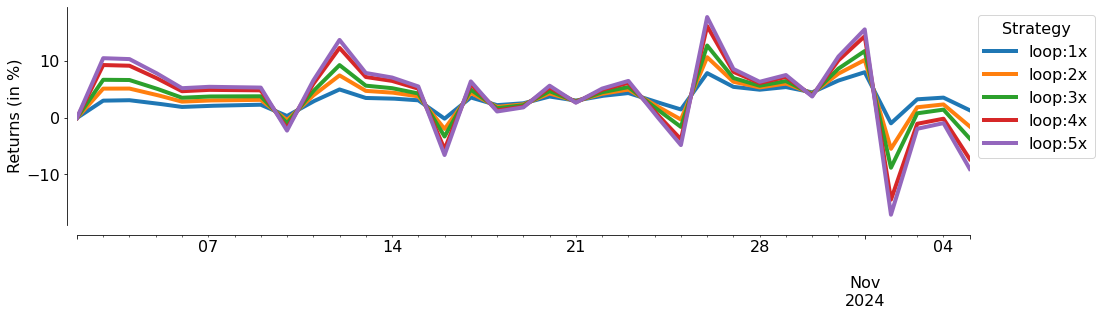

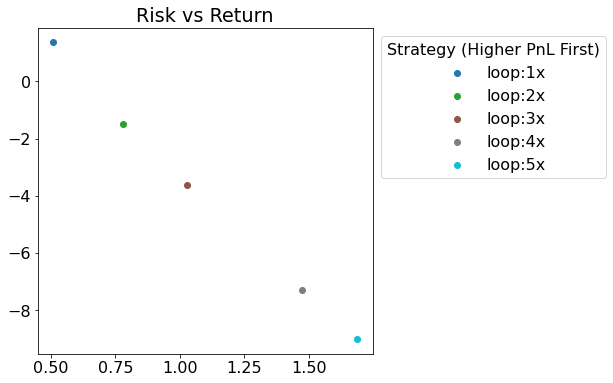

loop:1x    1.360835
loop:2x   -1.500935
loop:3x   -3.641040
loop:4x   -7.285103
loop:5x   -9.009072
dtype: float64


In [134]:
from dope.backengine.plotting.simple import Plotter

plotter = Plotter(summary)
plotter.summary_view()

In [ ]:
# Most of the PnL is due to price change:

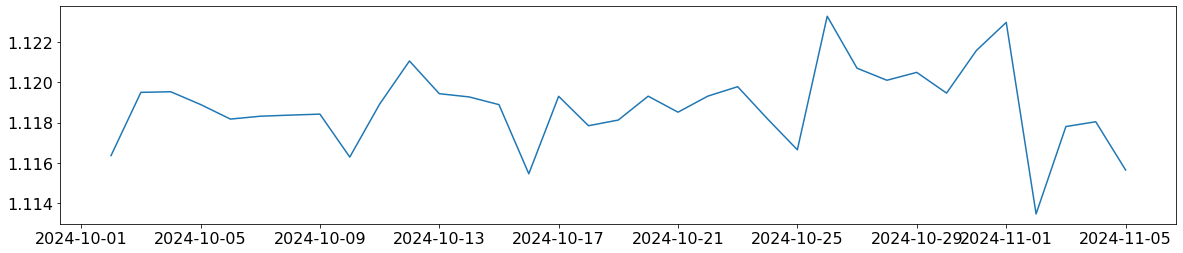

In [135]:
k = list(summary.keys())[0]
_filter  = bt.price_data._price.index >= summary[k].index[0]
_filter &= bt.price_data._price.index <= summary[k].index[-1]
plt.plot(bt.price_data._price[_filter].rETH)